In [1]:
!pip install langchain sentence-transformers --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.2 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which 

In [2]:
!pip install --upgrade transformers --q

##Step1: Loading and Preprocessing dataset

In [3]:
import pandas as pd
from tqdm import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load the dataset
df = pd.read_csv("/kaggle/input/anshlulla-dataset-1234567890/movie_scripts(cleaned).csv")

# Initialize RecursiveCharacterTextSplitter for chunking
max_chunk_size = 1024
text_splitter = RecursiveCharacterTextSplitter(chunk_size=max_chunk_size, chunk_overlap=100)

# Chunk scripts
all_chunks = []
for movie_name, script in tqdm(zip(df["Movie"], df["Scripts"]), desc="Chunking Scripts", total=len(df)):
    chunks = text_splitter.split_text(script)
    for i, chunk in enumerate(chunks):
        # Store each chunk with its corresponding movie name and chunk index
        all_chunks.append({"movie_name": movie_name, "chunk_index": i, "text": chunk})

Chunking Scripts: 100%|██████████| 1242/1242 [01:21<00:00, 15.32it/s]


##Step2: Creating Embeddings of the Chunks

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load Hugging Face embedding model
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model.to(device)

# Function to create embeddings for a list of texts
def get_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)  # Move inputs to GPU
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze()
    return embeddings.cpu().numpy()  # Move embeddings back to CPU and convert to NumPy

# Generate embeddings for each chunk in batches
chunk_texts = [chunk["text"] for chunk in all_chunks]
chunk_embeddings = []
batch_size = 16  

# Process texts in batches
for i in tqdm(range(0, len(chunk_texts), batch_size), desc="Generating Embeddings"):
    batch_texts = chunk_texts[i:i + batch_size]
    embeddings = get_embeddings(batch_texts)
    chunk_embeddings.extend(embeddings)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Generating Embeddings: 100%|██████████| 10563/10563 [05:41<00:00, 30.91it/s]


In [5]:
# Prepare data for vector storage
docs = [
    {
        "movie_name": all_chunks[i]["movie_name"],
        "chunk_index": all_chunks[i]["chunk_index"],
        "text": chunk_texts[i],
        "embedding": chunk_embeddings[i]
    }
    for i in range(len(chunk_texts))
]

##Step3: Storing all the chunks in a Vector Database

In [6]:
!pip install faiss-cpu --q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
import faiss
import numpy as np
import json

# Convert embeddings to a NumPy array
embeddings_array = np.array([doc['embedding'] for doc in docs]).astype('float32')  # Ensure dtype is float32

# Create a FAISS index using IVFFlat
nlist = 75  # Number of clusters
dimension = embeddings_array.shape[1]  # Dimension of embeddings
quantizer = faiss.IndexFlatL2(dimension)  # Flat index for quantization
index = faiss.IndexIVFFlat(quantizer, dimension, nlist)  # Create the inverted file index

# Train the index (required before adding vectors)
index.train(embeddings_array)

# Add embeddings to the index
index.add(embeddings_array)

# Store metadata for each embedding (movie name and chunk index)
metadata = [{"movie_name": doc["movie_name"], "chunk_index": doc["chunk_index"]} for doc in docs]

# Save the FAISS index and metadata to files for later retrieval
faiss.write_index(index, "movie_embeddings_ivf.index")  # Save the FAISS index
with open("metadata.json", "w") as f:
    json.dump(metadata, f)  # Save the metadata

print("FAISS IVFFlat index and metadata saved successfully.")

FAISS IVFFlat index and metadata saved successfully.


In [8]:
# Load the FAISS index
index = faiss.read_index("/kaggle/working/movie_embeddings_ivf.index")

# Load metadata from the JSON file
with open("/kaggle/working/metadata.json", "r") as f:
    metadata = json.load(f)

In [9]:
def retrieve_from_faiss(query, index, metadata, top_k=5):
    query_embedding = get_embeddings(query).astype('float32').reshape(1, -1)  # Reshape for FAISS
    distances, indices = index.search(query_embedding, top_k)
    retrieved_metadata = [metadata[i] for i in indices[0]]

    unique_results = {}
    for dist, meta in zip(distances[0], retrieved_metadata):
        movie_name = meta['movie_name']
        if movie_name not in unique_results:
            unique_results[movie_name] = {'chunk_index': meta['chunk_index'], 'distance': dist}
    
    # Ensure unique_results is a list of dictionaries
    return [{"movie_name": name, **data} for name, data in unique_results.items()]

In [10]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_from_faiss(query, index, metadata, top_k=5):
    """Retrieve top K results from FAISS."""
    query_embedding = get_embeddings(query).astype('float32').reshape(1, -1)  # Reshape for FAISS

    # Perform the search
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve the corresponding metadata
    retrieved_metadata = [metadata[i] for i in indices[0]]

    return retrieved_metadata, distances[0]  # Return both results and their distances

def get_query_embedding(query):
    """Get the embedding for the given query."""
    return get_embeddings(query).reshape(1, -1)  # Reshape for cosine similarity

def calculate_similarity(query_embedding, top_k_results, docs):
    """Calculate cosine similarity between the query embedding and top K chunk embeddings."""
    similarities = []

    for result in top_k_results:
        # Get the corresponding chunk from docs using movie name and chunk index
        doc = next((doc for doc in docs if doc['movie_name'] == result['movie_name'] and doc['chunk_index'] == result['chunk_index']), None)
        
        if doc is not None:
            chunk_embedding = np.array(doc['embedding']).reshape(1, -1)  # Ensure shape for cosine similarity
            similarity = cosine_similarity(query_embedding, chunk_embedding)[0][0]  # Get the scalar value
            similarities.append((doc, similarity))  # Store the document and its similarity score

    return similarities

def rank_results(similarities):
    """Rank results based on similarity scores."""
    # Sort the documents by similarity score in descending order
    ranked_results = sorted(similarities, key=lambda x: x[1], reverse=True)
    return ranked_results

# Example usage
query = "Describe a romantic scene in New York City where the characters share a dinner at a rooftop restaurant"
top_k_results, distances = retrieve_from_faiss(query, index, metadata)  # Step 1: Get top K results

query_embedding = get_query_embedding(query)  # Step 2: Get query embedding
similarities = calculate_similarity(query_embedding, top_k_results, docs)  # Step 3: Calculate similarities
ranked_results = rank_results(similarities)  # Step 4: Rank the results

# Display the top N results (e.g., top 5)
top_n = 5
for (result, score), distance in zip(ranked_results[:top_n], distances):
    print(f"Movie: {result['movie_name']}, Chunk Index: {result['chunk_index']}, "
          f"Distance: {distance:.4f}, Similarity Score: {score:.4f}")

Movie: American Psycho, Chunk Index: 0, Distance: 17.2213, Similarity Score: 0.4603
Movie: Godfather, Chunk Index: 98, Distance: 17.5089, Similarity Score: 0.4599
Movie: Chaos, Chunk Index: 74, Distance: 17.9674, Similarity Score: 0.4164
Movie: Purple Rain, Chunk Index: 60, Distance: 17.9847, Similarity Score: 0.4155
Movie: Sex and the City, Chunk Index: 149, Distance: 18.0041, Similarity Score: 0.4130


##Step4: Setting up Prompt Template and RAG Chain

In [11]:
!pip install -U langchain-community --q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
!pip install langchain transformers faiss-cpu --q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
import faiss
import numpy as np
import json

# Load the FAISS index
faiss_index = faiss.read_index("/kaggle/working/movie_embeddings_ivf.index")

# Load metadata from the JSON file
with open("/kaggle/working/metadata.json", "r") as f:
    metadata = json.load(f)


print(f"Loaded FAISS index with {faiss_index.ntotal} vectors.")
print(f"Loaded metadata for {len(metadata)} entries.")

Loaded FAISS index with 168994 vectors.
Loaded metadata for 168994 entries.


In [14]:
from langchain import LLMChain, PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import ChatPromptTemplate

In [15]:
# Convert metadata to the required format for docstore
docstore = {i: {"movie_name": doc["movie_name"], "chunk_index": doc["chunk_index"]} for i, doc in enumerate(metadata)}

# Create the index to docstore ID mapping
index_to_docstore_id = {i: i for i in range(len(metadata))}

# Initialize the FAISS vector store
vectorstore = FAISS(index, docstore, index_to_docstore_id, embeddings)

In [16]:
import gc
gc.collect()

104

In [17]:
torch.cuda.empty_cache()

In [18]:
!pip install langchain-google-genai --q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
!pip install --upgrade langchain-google-genai --q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
!pip install google-generativeai --q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)

False

In [59]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Provide your Google API Key: ")

Provide your Google API Key:  ·······································


In [61]:
user_query = """
Write an intense action scene set in the bustling streets of New York City at night. Two characters, 
skilled and resourceful, are evading a powerful enemy in a high-stakes pursuit. Capture the 
urgency, adrenaline, and tactical exchanges as they navigate tight alleyways, dodge obstacles, 
and strategize their next moves. The dialogue should be focused and sharp, highlighting their 
determination and quick thinking amidst the chaos. Also give me character descriptions 
"""

In [62]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-pro', 
                             temperature=0.9,
                             google_api_key=os.environ["GOOGLE_API_KEY"])

response = llm.invoke(user_query)
print(response.content)

**Character Descriptions:**

* **Jack:** A wiry, agile mercenary with a sharp eye and a cool demeanor.
* **Eva:** A cunning and resourceful street-smart woman with a knack for blending in.

**Scene:**

The night sky crackles with thunder as lightning illuminates the chaotic streets of New York City. The relentless downpour creates a symphony of noise against the concrete jungle.

Amidst the urban labyrinth, Jack and Eva sprint through a crowded intersection, their pursuers closing in. The enemy vehicles roar behind them, their headlights piercing the rain.

"Split up!" Eva shouts, dodging a speeding taxi.

Jack nods, veering into a narrow alleyway. Eva disappears into the throng of pedestrians.

As Jack navigates the winding alley, he feels a presence behind him. Turning swiftly, he spots a towering figure wielding a glinting knife.

"Not this time," he whispers, disarming his opponent with a swift maneuver.

Meanwhile, Eva races through a congested street, her sharp eyes scanning for 

In [67]:
import os
import time
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from langchain.memory import ConversationBufferWindowMemory
from sentence_transformers import SentenceTransformer
import faiss

# Initialize the Google Generative AI model
llm = ChatGoogleGenerativeAI(
    model='gemini-pro', 
    temperature=0.9,
    google_api_key=os.environ["GOOGLE_API_KEY"]
)

# Load the embedding model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embedding_model.eval()

# Define the initial generation prompt template

initial_prompt_template = ChatPromptTemplate.from_messages([
    ("system", """
        You are an expert screenwriter specializing in original movie scripts. You will generate a well-structured movie script based on the provided context, which is drawn from similar scripts. Your goal is to create a compelling, creative, and original script that is true to the user's description.

        Please ensure the following:
        1. **Script Quality**: Your script should have a clear and engaging narrative. Focus on dialogue, scene descriptions, and character development.
        2. **Avoid Hallucinations**: Do not invent details not directly related to the given context or the user's request. Stick closely to the details provided in the prompt and retrieved context.
        3. **Clarity & Structure**: Your script should be properly formatted with dialogue and scene descriptions that follow standard screenplay conventions.
        4. **Inappropriate Content Warning**: If the user asks for inappropriate, offensive, or harmful content (including but not limited to explicit violence, hate speech, or illegal activities), please politely refuse and issue a warning explaining that the requested content is not allowed.

        Example of your task:
        - Given a set of related scripts, you are to create a new movie script with a unique setting, characters, and plot, adhering to the style and tone specified by the user.
        - Always ensure that the content is respectful, appropriate for a broad audience, and adheres to industry standards for film content.
    """),

    ("user", """
        Here are similar scripts for inspiration:
        {context}

        Based on the context provided, please create a new script that fits the following description:
        {query}

        **Important Note**: 
        - The script should be creative and original, but should not include any inappropriate, harmful, or explicit content. 
        - Do not invent details that were not included in the provided context unless clearly instructed by the user.
        - Your script should align with the genre and mood suggested by the user, ensuring it is engaging and coherent.

        If you find the user's request to be inappropriate or harmful, kindly refuse to generate the content and issue a warning about acceptable content.
    """)
])


# Define the edit and follow-up prompt template
edit_prompt_template = ChatPromptTemplate.from_messages([
    ("system", """You are a screenwriter assistant helping refine a movie script. 
    Provide a detailed response about any of the following aspects based on the user's instructions:
    1. Dialogue Improvement
    2. Scene Flow
    3. Character Development
    4. Plot Progression
    5. Character Descriptions
    
    Choose one aspect to focus on based on the user's request."""), 

    ("user", """Current script:
    {generated_script}

    Conversation history:
    {history}
    
    User's edit or question:
    {query}
    """)
])


# Initialize memory with a window size of 50 for recent exchanges
memory = ConversationBufferWindowMemory(k=50, return_messages=True)

# Define the retrieval function
def retrieve_documents(query: str, top_k=5):
    query_embedding = embedding_model.encode(query).astype("float32")
    distances, indices = faiss_index.search(query_embedding.reshape(1, -1), top_k)
    retrieved_docs = [metadata[idx] for idx in indices[0] if idx != -1]
    return retrieved_docs

# Define the RAG chain with memory
class CustomRAGChain:
    def __init__(self, retriever, initial_template, edit_template, llm, memory):
        self.retriever = retriever
        self.initial_template = initial_template
        self.edit_template = edit_template
        self.llm = llm
        self.memory = memory
        self.generated_script = ""  # Stores the current generated script
        self.current_sources = []   # Stores sources for the current script

        
    def generate_script(self, user_query: str, retries=3):
        # Retrieve documents only for a new script generation
        retrieved_docs = self.retriever(user_query)

        if not retrieved_docs:
            return "No relevant documents found for script generation."

        # Format retrieved documents into context
        context = "\n".join([f"Movie: {doc['movie_name']}, Chunk: {doc['chunk_index']}" for doc in retrieved_docs])
        
        # Format the initial prompt with context and user query
        prompt = self.initial_template.format(context=context, query=user_query)

        attempt = 0
        while attempt < retries:
            attempt += 1
            try:
                # Generate a response from the model
                response = self.llm.invoke(prompt)
                if response and response.content:
                    self.generated_script = response.content  # Store the generated script
                    self.memory.save_context({"input": user_query}, {"output": response.content})

                    # Store the sources for this new script
                    self.current_sources = retrieved_docs

                    # Return the generated script along with sources
                    output = response.content + "\n\nSources for generated script:\n"
                    for doc in self.current_sources:
                        output += f"- Movie: {doc['movie_name']}, Chunk: {doc['chunk_index']}\n"

                    return output
            except Exception as e:
                time.sleep(2)  # Wait briefly before retrying

        return "Failed to generate script after multiple attempts. Please try again later."

    
    def handle_request(self, user_request: str):
        if not self.generated_script and user_request.lower().startswith("edit:"):
            return "No script has been generated yet to edit."

        # Decide whether to use the initial or edit template
        if user_request.lower().startswith("edit:"):
            edit_query = user_request[5:].strip()  # Extract edit instruction after "edit: "
            # Use the edit template
            prompt = self.edit_template.format(
                generated_script=self.generated_script, 
                history=self.memory.buffer, 
                query=edit_query
            )
        else:
            # Use the initial template to generate a new script
            return self.generate_script(user_request)

        # Pass the prompt to the model for either case
        response = self.llm.invoke(prompt)
        if response and response.content:
            self.generated_script = response.content  # Update or store the script with the response
            return response.content
        else:
            return "Failed to generate response. Please try again."

# Initialize the RAG chain with both templates
rag_chain = CustomRAGChain(
    retriever=retrieve_documents,
    initial_template=initial_prompt_template,
    edit_template=edit_prompt_template,
    llm=llm,
    memory=memory
)

# Function to handle the real-time chat with direct edits via the LLM
def real_time_chat():
    print("Welcome to the real-time script generation chat! Type 'exit' to quit.\n")
    
    while True:
        user_query = input("Enter your query (or type 'edit: <your edit request>' to modify the script): ")
        if user_query.lower() == "exit":
            print("Exiting chat. Goodbye!")
            break

        # Pass any query, including edits, directly to the RAG chain's handle_request
        response = rag_chain.handle_request(user_query)
        print("Response:", response)

real_time_chat()

Welcome to the real-time script generation chat! Type 'exit' to quit.



Enter your query (or type 'edit: <your edit request>' to modify the script):  Write an intense action scene set in the bustling streets of New York City at night. Two characters,  skilled and resourceful, are evading a powerful enemy in a high-stakes pursuit. Capture the  urgency, adrenaline, and tactical exchanges as they navigate tight alleyways, dodge obstacles,  and strategize their next moves. The dialogue should be focused and sharp, highlighting their  determination and quick thinking amidst the chaos.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Response: [SCENE START]

**EXT. NEW YORK CITY STREETS - NIGHT**

Amidst the hustle and bustle of the city, two figures dart through the shadowy streets:

AVA (25), agile and quick-witted, and JARED (30), a seasoned operative with a razor-sharp mind.

They are pursued by a relentless force, their heavy footsteps echoing through the concrete canyons.

AVA
Jared, they're gaining on us.

JARED
Stay sharp. Find an alley.

They spot an opening and surge into it. The narrow, trash-strewn passageway provides a temporary refuge.

AVA
We need to split up.

JARED
Agreed. I'll take the high ground.

AVA
I'll keep them busy down here.

Jared scales a fire escape, while Ava sprints towards the main street.

**EXT. NEW YORK CITY STREETS - CONTINUOUS**

Ava bursts out of the alley, colliding with the pursuers. She ducks and weaves through the oncoming assault, her fists and feet flashing.

Persuader (O.S.)
Don't let her get away!

**EXT. FIRE ESCAPE - CONTINUOUS**

Jared perches atop the fire escape, 

Enter your query (or type 'edit: <your edit request>' to modify the script):  edit: give me character descriptions


Response: **Character Descriptions:**

**Ava:**

* Age: 25
* Physical Attributes: Agile, athletic, and quick-witted with sharp reflexes and a lithe frame.
* Personality: Determined, resourceful, and highly skilled in combat. She thinks quickly on her feet and adapts to changing situations effortlessly. Ava is fiercely loyal to those she trusts and fiercely protective of her own.
* Motivation: To escape her pursuers and complete her mission, whatever it may be.
* Background: Trained as a special operative, Ava's past remains shrouded in mystery. She possesses a unique ability to blend into any environment and disappear at will.

**Jared:**

* Age: 30
* Physical Attributes: Seasoned and physically fit with a muscular build and piercing eyes.
* Personality: Calm, analytical, and a master strategist. Jared exudes confidence and authority, inspiring trust and respect in those around him. He is highly skilled in both combat and espionage.
* Motivation: To protect Ava and ensure the success o

Enter your query (or type 'edit: <your edit request>' to modify the script):  exit


Exiting chat. Goodbye!


In [22]:
!pip install diffusers --q -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
torch.cuda.empty_cache()

In [24]:
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Download the stopwords the first time you run the code
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import os
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPProcessor, CLIPModel

# Load the Stable Diffusion model for scene generation
model_path = "CompVis/stable-diffusion-v1-4" 
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Function to generate scenes using Stable Diffusion
def generate_scenes(prompt: str, n_images: int):
    """Generate multiple images based on the provided prompt."""
    images = []
    try:
        # Generate images using the pipeline with specified number of images per prompt
        images = pipe(prompt, num_images_per_prompt=n_images, num_inference_steps=50, guidance_scale=7.5).images
        return images
    except Exception as e:
        print(f"Error generating scenes: {e}")
        return None

# Function to calculate CLIP score
import torch

def calculate_clip_score(images, prompt):
    # Get the device of the model
    device = next(clip_model.parameters()).device
    
    # Preprocess images
    image_tensors = [preprocess(image).unsqueeze(0) for image in images]  # Ensure each image is batched
    image_tensor = torch.cat(image_tensors).to(device)  # Move images to the same device as the model

    # Get CLIP embeddings
    with torch.no_grad():
        # Move inputs to the same device
        inputs = clip_tokenizer(prompt, return_tensors="pt").to(device)  # Move text inputs to device
        image_features = clip_model.get_image_features(pixel_values=image_tensor)
        text_features = clip_model.get_text_features(**inputs)

    # Normalize features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    clip_scores = (image_features @ text_features.T).squeeze(0).cpu().numpy()  # Move scores back to CPU if needed

    return clip_scores


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [26]:
# Save the pretrained model
pipe.save_pretrained("/kaggle/working/stable_diffusion_model")

In [27]:
import shutil

# Path to the directory you want to download
model_dir = '/kaggle/working/stable_diffusion_model'

# Create a zip file of the directory
shutil.make_archive('/kaggle/working/stable_diffusion_model', 'zip', model_dir)


'/kaggle/working/stable_diffusion_model.zip'

Enter a prompt for scene generation (or type 'exit' to quit):  horror imge
How many images would you like to generate?  1


Generating 1 scenes for prompt: 'horror imge'


  0%|          | 0/50 [00:00<?, ?it/s]

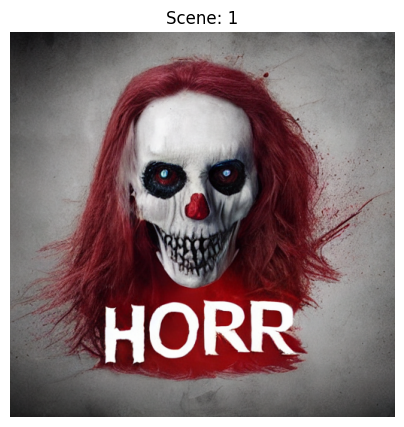

Enter a prompt for scene generation (or type 'exit' to quit):  romantic image
How many images would you like to generate?  1


Generating 1 scenes for prompt: 'romantic image'


  0%|          | 0/50 [00:00<?, ?it/s]

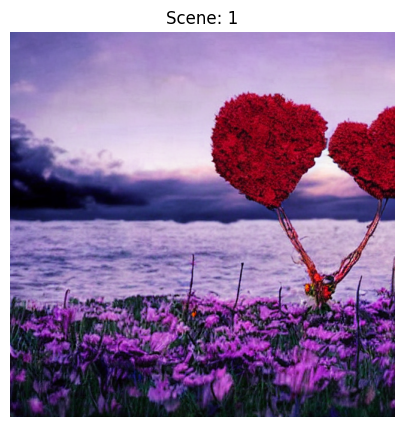

Enter a prompt for scene generation (or type 'exit' to quit):  two people on a data
How many images would you like to generate?  1


Generating 1 scenes for prompt: 'two people on a data'


  0%|          | 0/50 [00:00<?, ?it/s]

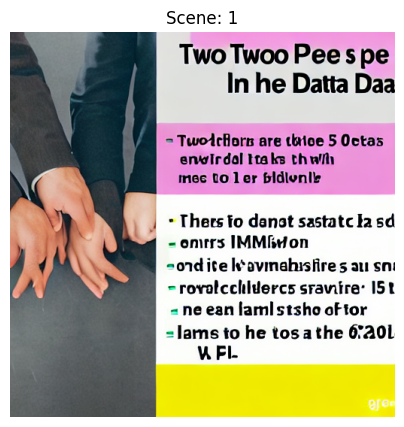

Enter a prompt for scene generation (or type 'exit' to quit):  two people on a date
How many images would you like to generate?  1


Generating 1 scenes for prompt: 'two people on a date'


  0%|          | 0/50 [00:00<?, ?it/s]

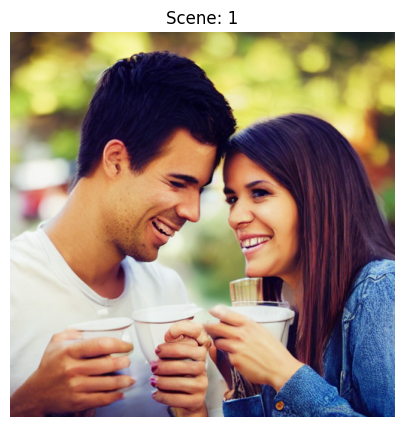

Enter a prompt for scene generation (or type 'exit' to quit):  exit


In [ ]:
# Loop to accept user prompts
while True:
    user_input = input("Enter a prompt for scene generation (or type 'exit' to quit): ")
    
    if user_input.lower() == 'exit':
        print("Exiting the scene generation.")
        break

    # Ask for the number of images to generate
    n_images = int(input("How many images would you like to generate? "))

    # Generate scenes based on user input
    print(f"Generating {n_images} scenes for prompt: '{user_input}'")
    images = generate_scenes(user_input, n_images)

    if images:
        for i, image in enumerate(images):
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Scene: {i+1}")
            plt.show() 

    else:
        print(f"Failed to generate images for prompt '{user_input}'. Please try again.")


In [37]:
img_prompts = [
    "A serene forest with sunlight filtering through the leaves",
    "A bustling city street at night with neon lights",
    "An alien landscape with strange plants and creatures",
    "A cozy cabin in the mountains during winter",
    "A futuristic cityscape with flying cars",
    "A tranquil beach during sunset with gentle waves",
    "A mysterious ancient ruin covered in vines",
    "A vibrant market filled with colorful fruits and vegetables",
    "A dark, enchanted castle shrouded in fog",
    "A beautiful garden full of blooming flowers and butterflies"
]


In [ ]:
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)  # Ensure the model is on the correct device

# Initialize the CLIP tokenizer
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16")

# Define the preprocess function without normalization
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# List to store all CLIP scores
all_clip_scores = []

# Loop through the predefined prompts
for user_input in img_prompts:
    n_images = 1  # number of images per prompt

    # Generate scenes based on the current prompt
    print(f"Generating {n_images} scenes for prompt: '{user_input}'")
    images = generate_scenes(user_input, n_images)

    if images:
        for i, image in enumerate(images):
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"Scene: {i + 1}")
            plt.show()

        # Calculate CLIP scores for the generated images
        try:
            # Tokenize the user input prompt
            inputs = clip_tokenizer(user_input, return_tensors="pt", padding=True, truncation=True).to(device)

            # Preprocess images
            image_tensors = [preprocess(image).unsqueeze(0).to(device) for image in images]  # Ensure each image is batched
            image_tensor = torch.cat(image_tensors)  # Concatenate images into a single batch
            
            # Get CLIP embeddings
            with torch.no_grad():
                image_features = clip_model.get_image_features(pixel_values=image_tensor)
                text_features = clip_model.get_text_features(input_ids=inputs["input_ids"])  # Pass the tokenized input
            
            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            
            # Compute cosine similarity
            clip_scores = (image_features @ text_features.T).cpu().numpy().flatten()  # Flatten to 1D array
            all_clip_scores.extend(clip_scores.tolist())  # Store scores in the list
            print(f"CLIP scores for the generated images: {clip_scores}")

        except Exception as e:
            print(f"Error calculating CLIP scores: {e}")
    else:
        print(f"Failed to generate images for prompt '{user_input}'. Please try again.")


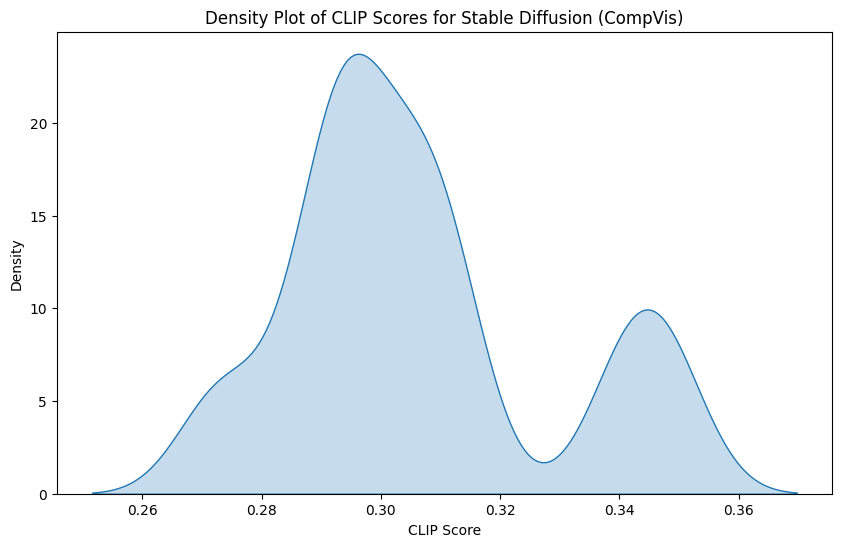

In [39]:
import warnings
warnings.filterwarnings("ignore")

# Create KDE plot of the CLIP scores
plt.figure(figsize=(10, 6))
sns.kdeplot(all_clip_scores, fill=True, bw_adjust=0.5)
plt.title("Density Plot of CLIP Scores for Stable Diffusion (CompVis)")
plt.xlabel("CLIP Score")
plt.ylabel("Density")
plt.show()

In [28]:
prompts = [
    "She opened the old book",
    "Running through the forest",
    "Waiting at the train station",
    "A loud noise startled him",
    "The letter was unexpected",
    "In the quiet of the night",
    "The ocean waves crashed",
    "She looked out the window",
    "A dog barked in the distance",
    "Watching the storm roll in",
    "He unlocked the front door",
    "Looking up at the stars",
    "The coffee shop was crowded",
    "Walking down the busy street",
    "She held onto the railing",
    "Whispers filled the room",
    "The sun was setting slowly",
    "Standing by the fireplace",
    "The phone rang unexpectedly",
    "He flipped through the pages",
    "She tightened her scarf",
    "In the middle of the road",
    "A stranger passed by silently",
    "Looking through old photos",
    "The cat sat on the windowsill",
    "She laughed softly to herself",
    "Listening to the waves crash",
    "An eerie silence filled the air",
    "The keys jangled in his hand",
    "A child giggled nearby",
    "The wind howled outside",
    "Reading by the candlelight",
    "The door creaked open slowly",
    "Snowflakes began to fall",
    "The fire crackled warmly",
    "The city lights glimmered",
    "She traced patterns in the sand",
    "Waiting for the elevator",
    "A bird chirped in the tree",
    "The rain poured down hard",
    "Walking along the riverbank",
    "She picked up the phone",
    "He dusted off his old shoes",
    "A soft melody played nearby",
    "The streets were eerily empty",
    "The clock ticked loudly",
    "She pulled her coat tighter",
    "They shared a quiet glance",
    "The candle flickered out",
    "She hummed a tune softly",
    "He adjusted his glasses",
    "The suitcase was heavy",
    "The bell chimed in the distance",
    "A shadow crossed the wall",
    "She tiptoed across the floor",
    "The trees swayed gently",
    "The night was calm and clear",
    "He scratched his head, puzzled",
    "The library was deserted",
    "She sipped her tea thoughtfully",
    "A light breeze brushed by",
    "The curtains swayed slightly",
    "He looked down at his hands",
    "The clock struck midnight",
    "She clicked her pen nervously",
    "He stepped into the cold air",
    "The alleyway was dark and damp",
    "She fiddled with her necklace",
    "The painting was mesmerizing",
    "A soft laugh broke the silence",
    "He leaned against the wall",
    "The music played softly",
    "The sky was a deep shade of blue",
    "She sat alone in the café",
    "He poured another cup of coffee",
    "The trees rustled quietly",
    "The sun peeked through the clouds",
    "He picked up the old photograph",
    "The streetlights flickered",
    "A cat meowed nearby",
    "The letter lay unopened",
    "He zipped up his jacket",
    "The garden was in full bloom",
    "She tugged at her sleeves",
    "The river flowed gently",
    "The night air was chilly",
    "She brushed her hair aside",
    "The room was dimly lit",
    "He leaned over the railing",
    "A leaf floated to the ground",
    "The ice clinked in her glass",
    "A faint smell of roses lingered",
    "He adjusted his collar",
    "The smell of rain was in the air",
    "She tapped her fingers lightly",
    "The path was lined with trees",
    "The lake was calm and still",
    "He adjusted his tie nervously",
    "The sand was warm underfoot",
    "She lit a candle carefully"
]

In [41]:
len(prompts)

100

In [42]:
def calculate_similarity(embedding1, embedding2):
    # Calculate the cosine similarity between two embeddings
    cos_sim = np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    return cos_sim

In [43]:
def evaluate_prompts(prompts, llm, embedding_model, batch_size=5):
    results = []
    
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i:i + batch_size]
        responses = []

        # Generate responses from the Gemini model for the batch
        for prompt in batch_prompts:
            try:
                # Generate a response from the model
                response = llm.invoke(prompt)
                responses.append(response)  # Append the full response object
            except Exception as e:
                print(f"Error generating response for prompt: {prompt} - {str(e)}")
                responses.append(None)  # Append None or a default value on error

        # Process each response and append to results
        for prompt, response in zip(batch_prompts, responses):
            if response and response.content:
                generated_output = response.content
                
                # Get embeddings for the prompt and the generated output
                prompt_embedding = embedding_model.encode(prompt).astype("float32")
                output_embedding = embedding_model.encode(generated_output).astype("float32")

                # Calculate the similarity
                similarity = calculate_similarity(prompt_embedding, output_embedding)
                
                # Append the results: (prompt, generated_output, similarity)
                results.append((prompt, generated_output, similarity))
        
        # Clear responses to free up resources
        responses.clear()

    return results


In [44]:
evaluation_results = evaluate_prompts(prompts, llm, embedding_model, batch_size=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Error generating response for prompt: Standing by the fireplace - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The phone rang unexpectedly - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: He flipped through the pages - 429 Resource has been exhausted (e.g. check quota).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Error generating response for prompt: Waiting for the elevator - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: A bird chirped in the tree - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The rain poured down hard - 429 Resource has been exhausted (e.g. check quota).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Error generating response for prompt: She picked up the phone - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: He dusted off his old shoes - 429 Resource has been exhausted (e.g. check quota).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Error generating response for prompt: A light breeze brushed by - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: He looked down at his hands - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The clock struck midnight - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: She clicked her pen nervously - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The alleyway was dark and damp - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: She fiddled with her necklace - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The painting was mesmerizing - 429 Resource has been exhausted (e.g. check quota).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Error generating response for prompt: She brushed her hair aside - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The room was dimly lit - 429 Resource has been exhausted (e.g. check quota).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Error generating response for prompt: The ice clinked in her glass - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: A faint smell of roses lingered - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: He adjusted his collar - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The smell of rain was in the air - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: She tapped her fingers lightly - 429 Resource has been exhausted (e.g. check quota).
Error generating response for prompt: The path was lined with trees - 429 Resource has been exhausted (e.g. check quota).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
similarity_scores = [sim for _, _, sim in evaluation_results]

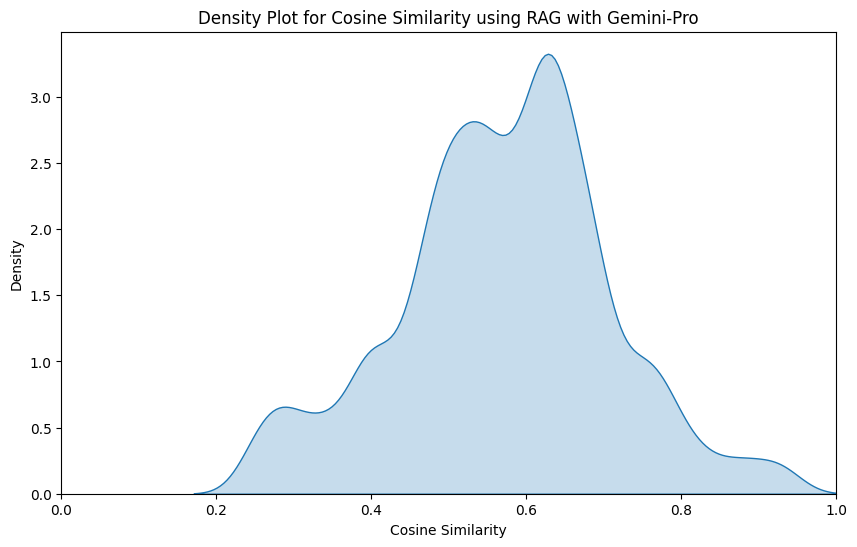

In [46]:
import warnings
warnings.filterwarnings("ignore")

# Plotting the KDE of cosine similarity values
plt.figure(figsize=(10, 6))
sns.kdeplot(similarity_scores, fill=True, bw_adjust=0.5)
plt.title('Density Plot for Cosine Similarity using RAG with Gemini-Pro')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.show()

In [48]:
avg_clip_score = sum(all_clip_scores) / len(all_clip_scores)
avg_clip_score

0.3061481386423111

In [50]:
avg_cosine_similarity = sum(similarity_scores) / len(similarity_scores)
avg_cosine_similarity

0.5712846851348877